In [1]:
from py_vollib.black_scholes.implied_volatility import implied_volatility 
from py_vollib.black_scholes import black_scholes as prc 
from py_vollib.black_scholes.greeks.numerical import delta as delta
import numpy as np
import scipy.io
import torch
import matplotlib.pyplot as plt
import glob
import os


os.chdir(r'C:\Users\s0837263\Desktop\Plots_Robust_SDEs\GOOG_data')

S0 [800.114]
rates [[0.05]
 [0.05]
 [0.05]
 [0.05]
 [0.06]
 [0.05]
 [0.05]
 [0.05]
 [0.05]
 [0.06]
 [0.05]
 [0.05]]
rate [0.05]
IV_target [[0.40809244 0.38974069 0.37173414 0.3543446  0.33760641 0.32147476
  0.30591119 0.30591119 0.29107256 0.29107256 0.27728939 0.27728939
  0.26503486 0.26503486 0.25480122 0.25480122 0.24682345 0.24682345
  0.24109123 0.24109123 0.23729865 0.23729865 0.23479501 0.23479501
  0.23284793]
 [0.35863737 0.35863737 0.33689252 0.33689252 0.31513388 0.31513388
  0.29351872 0.29351872 0.27245849 0.27245849 0.25263475 0.25263475
  0.2348992  0.2348992  0.21992496 0.21992496 0.20806776 0.20806776
  0.19944758 0.19944758 0.19365363 0.19365363 0.18970951 0.18970951
  0.18653162]
 [0.35680567 0.3397084  0.32265687 0.30574603 0.28903884 0.28903884
  0.2727061  0.2727061  0.25698329 0.25698329 0.24214869 0.22852055
  0.21635435 0.20579977 0.20579977 0.19695478 0.19695478 0.18985575
  0.18985575 0.18435827 0.18435827 0.1800677  0.1764909  0.1764909
  0.17319479]]
matu

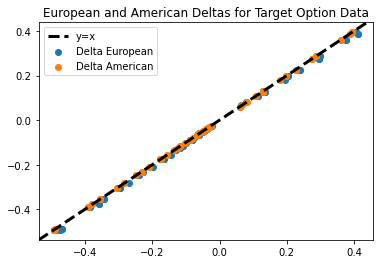

In [2]:
# get data for each calibration 
cal_day = 2 # choose calibration day 0,1,2,...,10
GOOG_ALL = scipy.io.loadmat('GOOG_S0.mat')['GOOG_S0']/1
np.save('GOOG_ALL.npy',GOOG_ALL)
#print('GOOG all', GOOG_ALL)
GOOG_S0 =  scipy.io.loadmat('GOOG_S0.mat')['GOOG_S0'][cal_day]/1
print('S0',GOOG_S0)
#GOOG_S0 = GOOG_S0.astype('float32')
rate = scipy.io.loadmat('rates.mat')['rates'][0]/1 # pick 0.05 interest rate for all calibration dates
#rate = rate.astype('float32')
print('rates',scipy.io.loadmat('rates.mat')['rates'] )
print('rate',rate)
market_iv = scipy.io.loadmat('IV_target.mat')['IV_blend_smooth'][cal_day,:,:]
print('IV_target',market_iv)
maturities = scipy.io.loadmat('maturities.mat')['maturities'][cal_day,:]/365
maturity_exotic = (scipy.io.loadmat('timegrids.mat')['GOOG_timegrids'][0,11])/365
print('maturities',maturities)
strikes = scipy.io.loadmat('strikes.mat')['K'][cal_day,:,:]/1
delta_market = scipy.io.loadmat('delta.mat')['Delta'][cal_day,:,:]
print('strikes',strikes)
timegrid = scipy.io.loadmat('timegrids.mat')['GOOG_timegrids'][cal_day,0:12]/365 # adjust timegrid to allign with last vanilla maturity
timegrid_exotic = scipy.io.loadmat('timegrids.mat')['GOOG_timegrids'][0,0:12]/365 # fixed for all calibration days
print('timegrid',timegrid)
print('timegrid_daily_exotic',timegrid_exotic*365)
print('timegrid_daily', 365*timegrid)
prices =np.zeros_like(market_iv)
np.save('maturities.npy',maturities)
np.save('timegrid_exotic.npy',timegrid_exotic)
np.save('GOOG_S0.npy',GOOG_S0 )
np.save('cal_day.npy', cal_day)
np.save('timegrid.npy',timegrid)
np.save('strikes.npy',strikes)
np.save('maturity_exotic.npy',maturity_exotic )
print('maturity exotic', maturity_exotic)
print('maturity_exotic_daily', maturity_exotic*365)
print('strikes datatype',strikes.dtype)
number_maturities=len(maturities)
number_strikes=25 # we repeat strikes if there is not enough liquid data (repeated strikes are discarded during calibration)
print('number_strikes', number_strikes)
print('number_maturities',number_maturities)
print('maturities_daily',scipy.io.loadmat('maturities.mat')['maturities'][cal_day,:] )

target_prices = np.zeros((number_maturities,number_strikes))
deltas = np.zeros((number_maturities,number_strikes))

np.save('market_iv.npy',market_iv)

S0 = GOOG_S0

np.save('rates.npy',rate)
print('rates datatype',rate.dtype)


for k in range(0,number_maturities):
    for j in range(0,number_strikes):
                # -1/365 corresponds to the options expiring on the day close prior to the actual maturity 
                if strikes[k,j]>S0:
                    target_prices[k,j]=prc(flag='c',S=S0,K=strikes[k,j],t=maturities[k]-1/365,r=rate,sigma=market_iv[k,j])
                    deltas[k,j]=delta(flag='c',S=S0,K=strikes[k,j],t=maturities[k]-1/365,r=rate,sigma=market_iv[k,j]) 
                else:
                    target_prices[k,j]=prc(flag='p',S=S0,K=strikes[k,j],t=maturities[k]-1/365,r=rate,sigma=market_iv[k,j])
                    deltas[k,j]=delta(flag='p',S=S0,K=strikes[k,j],t=maturities[k]-1/365,r=rate,sigma=market_iv[k,j]) 
            
#print('target_prices',target_prices) # calculated from market IV deltas 
np.save('target_prices.npy',target_prices)
#print('deltas',deltas) # to check if those are matched closely by the market deltas 
#print('deltas market', delta_market)
#print('delta diff', delta_market-deltas)

plt.scatter(deltas, delta_market,label='Delta European')
plt.scatter(delta_market, delta_market,label='Delta American')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False,label='y=x')
plt.title('European and American Deltas for Target Option Data')
plt.legend()
#plt.savefig("deltas.pdf")
plt.show()

                   

In [3]:
model_IV_fit = np.zeros_like(scipy.io.loadmat('IV_target.mat')['IV_blend_smooth'][0:12,:,:]/1)
model_IV_fit_previous = np.zeros_like(scipy.io.loadmat('IV_target.mat')['IV_blend_smooth'][0:12,:,:]/1)
model_price_fit = np.zeros_like(model_IV_fit)
model_price_fit_previous = np.zeros_like(model_IV_fit)
model_price_fit_target = np.zeros_like(model_IV_fit)
model_price_fit_target_previous = np.zeros_like(model_IV_fit)


files = glob.glob("NSDE_*tar")
files_prev_model_fit = [f for f in files if "initial"  in f]
files_model_fit = [f for f in files if "test"  in f]


maturities_all_cal_days = scipy.io.loadmat('maturities.mat')['maturities'][0:12,:]/365

count_prev_fit = 1
for filename in files_prev_model_fit:
    print('filename',filename)
    checkpoint = torch.load(filename, map_location="cpu")
    vanilla_pred = checkpoint["pred"].reshape(3,25).numpy()
    vanilla_target =  checkpoint["target_option_prices"].reshape(3,25).numpy()             
    model_price_fit_previous[count_prev_fit,:,:]=vanilla_pred.astype('float32')
    model_price_fit_target_previous[count_prev_fit,:,:]=vanilla_target.astype('float32')
    count_prev_fit +=1
    
count_model_fit =0    
for filename in files_model_fit:
    print('filename',filename)
    checkpoint = torch.load(filename, map_location="cpu")
    vanilla_pred = checkpoint["pred"].reshape(3,25).numpy()
    vanilla_target =  checkpoint["target_option_prices"].reshape(3,25).numpy()   
    model_price_fit[count_model_fit,:,:]=vanilla_pred.astype('float32')
    model_price_fit_target[count_model_fit,:,:]=vanilla_target.astype('float32')
    count_model_fit +=1
     
    
rate = rate.astype('float32')    
for cal_day in range(0,12):
    GOOG_S0 =  scipy.io.loadmat('GOOG_S0.mat')['GOOG_S0'].astype('float32')
    maturities = (scipy.io.loadmat('maturities.mat')['maturities'][cal_day,:]/365).astype('float32')
    number_maturities=len(maturities)
    strikes = scipy.io.loadmat('strikes.mat')['K'][cal_day,:,:].astype('float32')
    for k in range(0,number_maturities):
        for j in range(0,number_strikes):
                model_price = model_price_fit[cal_day,k,j].astype('float32')
                if cal_day>0:
                    model_price_prev = model_price_fit_previous[cal_day,k,j].astype('float32')
                    if strikes[k,j]>GOOG_S0[cal_day]:
                        try:
                            model_IV_fit_previous[cal_day,k,j]=implied_volatility(model_price_prev,  S=GOOG_S0[cal_day], K=strikes[k,j], r=rate[0], t=maturities[k]-1/365, flag="c")
                        except:
                            print('Below intristic value IV', cal_day)
                            pass
                    else:
                        try:
                            model_IV_fit_previous[cal_day,k,j]=implied_volatility(model_price_prev,  S=GOOG_S0[cal_day], K=strikes[k,j], r=rate[0], t=maturities[k]-1/365, flag="p")
                
                        except:
                            print('Below intristic value IV', cal_day)
                            pass
                if strikes[k,j]>GOOG_S0[cal_day] :
                      model_IV_fit[cal_day,k,j]=  implied_volatility(model_price,  S=GOOG_S0[cal_day], K=strikes[k,j], r=rate[0], t=maturities[k]-1/365, flag="c")
                else:
                      model_IV_fit[cal_day,k,j]= implied_volatility(model_price,  S=GOOG_S0[cal_day], K=strikes[k,j], r=rate[0], t=maturities[k]-1/365, flag="p")      

# save data to load into matlab to plot accuracy of Neural SDEs calibration to target IV surfaces                         
scipy.io.savemat('model_IV_fit.mat', {'model_IV_fit': model_IV_fit})                    
scipy.io.savemat('model_IV_fit_previous.mat', {'model_IV_fit_previous': model_IV_fit_previous})

print(model_IV_fit-scipy.io.loadmat('IV_target.mat')['IV_blend_smooth'][0:12,:,:]/1)
print(model_IV_fit_previous-scipy.io.loadmat('IV_target.mat')['IV_blend_smooth'][0:12,:,:]/1)
    

filename NSDE_model_initial_prices_LSV_seed_456_cal_day_1.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day_2.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day_3.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day_4.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day_5.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day_6.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day_7.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day_8.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day_9.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day__10.pth.tar
filename NSDE_model_initial_prices_LSV_seed_456_cal_day__11.pth.tar
filename NSDE_test_LSV_seed_456_cal_day_0.pth.tar
filename NSDE_test_LSV_seed_456_cal_day_1.pth.tar
filename NSDE_test_LSV_seed_456_cal_day_2.pth.tar
filename NSDE_test_LSV_seed_456_cal_day_3.pth.tar
filename NSDE_test_LSV_seed_456_cal_day_4.pth.tar
filename NSDE_test_L

In [5]:
from PIL import Image

files_1 = glob.glob("Target*png")
files_2 = glob.glob("Model*png")
files=files_1+files_2

for filename in files:
    print('filename',filename)
    image1 = Image.open(filename)
    im1 = image1.convert('RGB')
    len_string=len(filename)
    im1.save(filename[:len_string-4]+'.pdf')
    


filename Target_Data_Date152013Maturity17.png
filename Target_Data_Date152013Maturity2.png
filename Target_Data_Date152013Maturity9.png
filename Target_Data_Date1842013Maturity15.png
filename Target_Data_Date1842013Maturity2.png
filename Target_Data_Date1842013Maturity8.png
filename Target_Data_Date1942013Maturity14.png
filename Target_Data_Date1942013Maturity21.png
filename Target_Data_Date1942013Maturity7.png
filename Target_Data_Date2242013Maturity11.png
filename Target_Data_Date2242013Maturity18.png
filename Target_Data_Date2242013Maturity4.png
filename Target_Data_Date2342013Maturity10.png
filename Target_Data_Date2342013Maturity17.png
filename Target_Data_Date2342013Maturity3.png
filename Target_Data_Date2442013Maturity16.png
filename Target_Data_Date2442013Maturity2.png
filename Target_Data_Date2442013Maturity9.png
filename Target_Data_Date252013Maturity16.png
filename Target_Data_Date252013Maturity22.png
filename Target_Data_Date252013Maturity8.png
filename Target_Data_Date2542